# CE-40717: Machine Learning

## HW8-Clustering & Reinforcement Learning

### Kmeans & GMM:

At this question, we tend to implement Kmeans & GMM algorithms. For this purpose, `DO NOT EMPLOY` ready-for-use python libraries. Use this implementation for solving the following questions. Kmeans should continue till centeroids won't change. Furthermore, GMM also should continue till the difference of two consecutive likelihood logarithm would be less than 0.1. Notice that after executing the Kmeans part, the primitive centroids of GMM should be identical with ultimate Kmeans centroids.

In [11]:
from sklearn.datasets import make_classification, make_moons, make_circles, make_blobs
import numpy as np
from scipy.stats import multivariate_normal
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
EPS = np.finfo(float).eps

#### Part 1:

Utilize the subsequent cell in order to create the Dataset. Afterwards, try to execute the algorithm with k=2 centroids. At Kmeans, it is recommended to execute the algorithm with several various starting states in order to eventually choose the best respective result.

In [13]:
X,Y = make_classification(n_samples=700, n_features=10, n_informative=5,
                          n_redundant=0, n_clusters_per_class=2, n_classes=3)

##### Kmeans

In [14]:
class KMeans:
    
    k = 0
    
    def __init__(self, k, max_iter=2000, low=-5, high=5):
        self.k = k
        self.low=low
        self.high=high
        self.max_iter = max_iter
    
    def init_μs(self):
        self.μ = np.random.uniform(low=self.low, high=self.high, size=(self.k , self.X.shape[1]))
    
    def update_centroids(self):
        new_μ = self.μ.copy()
        for idx, center in enumerate(self.μ):
            if X[self.labels == idx , :].any():
                new_μ[idx] = np.mean(X[self.labels == idx , :] , axis=0)
        return new_μ
            
    def update_labels(self):
        labels = np.zeros((X.shape[0]))
        for idx, x in enumerate(self.X):
            x_r = x.reshape((1, -1))
            labels[idx] = np.argmin(np.linalg.norm(self.μ - x_r, axis=1, ord=2))
        
        self.labels = labels
    
    def run_multiple(self, X, times):
        results = {}
        for i in range(times):
            self.run(X)
            a = self.μ[0]
            b = self.μ[1]
            k = 0
            while(k < len(a) and k < len(b) and a[k] == b[k]):
                k+=1

            a_smaller = True
            if k < len(a) and k < len(b):
                if a[k] > b[k]:
                    a_smaller = False
            if a_smaller:
                save = tuple(a.tolist() + b.tolist())
            else:
                save = tuple(b.tolist() + a.tolist())

            if save in results:
                results[save] += 1
            else:
                results[save] = 1
    
        self.μ = np.array([k for k, v in reversed(sorted(results.items(), key=lambda item: item[1]))][0]).reshape(2 , -1)
        self.update_labels()
    def run(self , X):
        self.X = X
        self.init_μs()
        p = 0
        while(p <= self.max_iter):
            self.update_labels()
            new_μ = self.update_centroids()
            eq = True
            for i in range(self.k):
                if np.array_equal(self.μ[i], new_μ[i]) == False:
                    eq = False
                    break
            if eq:
                break
            else:
                self.μ = new_μ
            p += 1

##### Gaussian Mixture Model

In [16]:
class GMM:
    
    k = 0
    
    def __init__(self, k):
        self.k = k
    
    def init_μs(self , μ):
        self.μ = μ.copy()

    def init_πs(self):
        self.π = np.full(shape=self.k, fill_value=1/self.k)

    def init_Σs(self):
        self.Σ = np.full(shape=(self.k, self.X.shape[1], self.X.shape[1]), fill_value=np.cov(X.T))

    def gaussian(x, μ, Σ):
        return 
    
    def update_relative_weights(self):
        liklihood = np.zeros((self.X.shape[0], self.k))        
        r = np.zeros((self.X.shape[0], self.k))
        for i in range(self.X.shape[0]):
            for c in range(self.k):
                liklihood[i, c] = multivariate_normal(self.μ[c], self.Σ[c], allow_singular=True ).pdf(X[i].T)
                r[i, c] = self.π[c] * liklihood[i, c]
        
        r = r/r.sum(axis=1, keepdims=True)
            
        return r, np.log(liklihood + EPS)
    
    def get_labels(self):
        return np.argmax(self.r, axis=1)
    
    def update_params(self):
        
        self.π = self.r.mean(axis=0)
        for c in range(self.k):
            self.μ[c] = np.multiply(self.r[:,c:c+1].repeat(self.X.shape[1], 1), self.X).sum(axis=0)
            self.μ[c] = self.μ[c]/self.r[:,c:c+1].sum()
        
        for c in range(self.k):
            current_val = np.zeros((self.X.shape[1] , self.X.shape[1]))
            for i in range(self.X.shape[0]):
                term = (X[i] - self.μ[c]).reshape((1,-1))
                current_val = current_val + self.r[i,c] * np.dot(term.T, term)
            
            self.Σ[c] = current_val
            self.Σ[c] = self.Σ[c]/self.r[:,c:c+1].sum()
            
    def run(self , X, μ, max_iter):
        self.X = X
        self.init_μs(μ)
        self.init_πs()
        self.init_Σs()

        p = 0
        last_l = None
        while(p <= max_iter):
            r, new_l = self.update_relative_weights()
            if (last_l is not None) and np.allclose(last_l, new_l, rtol=0, atol=0.1):
                break
            else:
                self.r = r
                last_l = new_l
            
            self.update_params()
            p += 1

#### Part 2:

In a separated cell, implement `Purity` and `Rand-Index` criteria in order to compare the performance of mentioned algorithms.

In [26]:
def purity(y_true, y_pred, k):
    N = len(y_true)
    conf_mat = np.zeros((k,k))
    for i in range(N):
        conf_mat[int(y_pred[i])][int(y_true[i])] += 1
    return round(np.max(conf_mat, axis=1).sum() / N, 2)

In [27]:
def rand_index(y_true, y_pred, k):
    a = 0
    b = 0
    c = 0
    d = 0
    
    N = len(y_true)
    conf_mat = np.zeros((k,k))
    for i in range(N):
        for j in range(N):
            if i == j:
                continue
                
            if y_true[i] == y_true[j] and y_pred[i] == y_pred[j]:
                a += 1
            if y_true[i] != y_true[j] and y_pred[i] != y_pred[j]:
                b += 1
            if y_true[i] == y_true[j] and y_pred[i] != y_pred[j]:
                c += 1
            if y_true[i] != y_true[j] and y_pred[i] == y_pred[j]:
                d += 1
    return round((a + b) / (a + b + c + d), 2)

#### Part 3:

Use the following cell in order to create new Datasets. Afterwards, try to execute mentioned algorithms on new Dataset and eventually compare the recent results with the help of visualization(there is no problem for using relevant python libraries like `matplotlib`). Consider two clusters for this part.

In [35]:
def run_both(X, Y):
    kmeans = KMeans(k=2)
    kmeans.run_multiple(X, 15)

    gmm = GMM(k=2)
    gmm.run(X, μ=kmeans.μ, max_iter=10000)
    
    fig, axs = plt.subplots(ncols=2,  sharex=True, figsize=(9,4))
    
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=kmeans.labels, ax=axs[0]).set(title=f'Kmeans\nPurity: {purity(Y, kmeans.labels, 2)}\nRandIndex: {rand_index(Y, kmeans.labels, 2)}')
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=gmm.get_labels(), ax=axs[1]).set(title=f'GMM\nPurity: {purity(Y, gmm.get_labels(), 2)}\nRandIndex: {rand_index(Y, gmm.get_labels(), 2)}')
    
    return kmeans, gmm

In [47]:
X, Y = make_classification(n_samples=700, n_features=2, n_informative=2, n_redundant=0, n_classes=2)

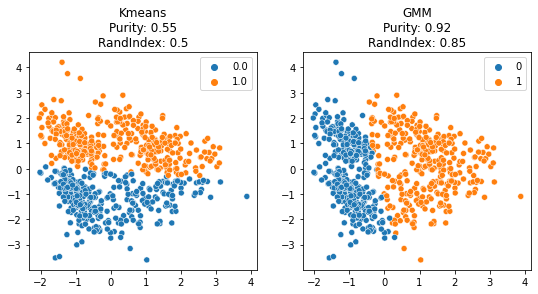

In [48]:
kmeans, gmm = run_both(X, Y)

In [38]:
X, Y = make_moons(n_samples=700, noise=0.2)

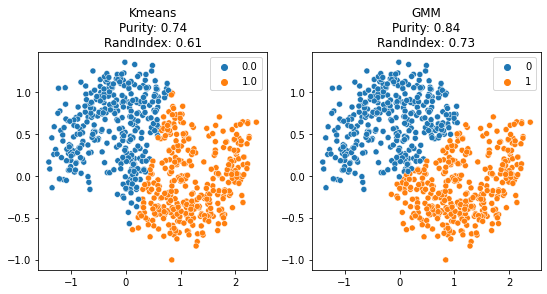

In [39]:
kmeans, gmm = run_both(X, Y)

In [51]:
X, Y = make_circles(n_samples=700, noise=0.2)

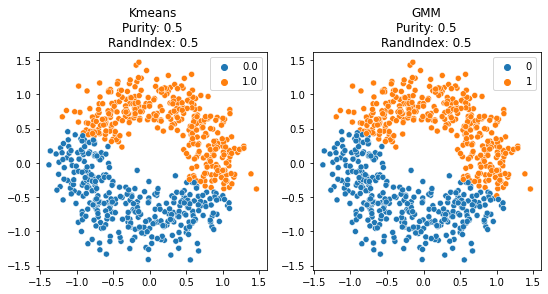

In [52]:
kmeans, gmm = run_both(X, Y)

### Reinforcement Learning:

At the bellow cell, besides the required libraries have been imported, feel free for changing the num_states variable with your desired number.

In [2]:
import numpy as np
import random
import gym
import time

In [3]:
env = gym.make("MountainCar-v0")
num_actions = 3
num_each_dim = 100
q_table = np.random.uniform(low=-1.5, high=0, size=(num_each_dim, num_each_dim, num_actions))

#### Part 1:

Next cell wants you supplement two functions. First for transforming the continuous space into discrete one (in order to make using q_table feasible), second for updating q_values based on the last action done by agent.

In [4]:
def discretize_state(env, state, num_each_dim):
    window = (env.observation_space.high - env.observation_space.low) / num_each_dim
    return tuple(((state - env.observation_space.low) / window).astype(np.int))

def env_state_to_Q_state(state):
    [position, velocity] = state
    return discretize_state(env, state, num_each_dim)

def update_q(q_table, current_state, new_state, action, learning_rate, reward, discount_factor):
    q_table[current_state + (action,)] = (1 - learning_rate) * q_table[current_state + (action,)] + learning_rate * (reward + discount_factor * np.max(q_table[new_state]))

#### Part 2:

At the following cell, the ends of two functions are getting current action based on the policy and defining the training process respectively.

In [5]:
def get_action(q_table, state):
    return np.argmax(q_table[state])


def q_learning():
    learning_rate = 0.15
    discount_factor = 0.95
    episods = 1000000
    
    epsilon = 1
    epsilon_first = 1
    epsilon_last = episods//10
    epsilon_decay = epsilon/(epsilon_last - epsilon_first)

    
    for episode in range(episods):
        current_state_d = discretize_state(env, env.reset(), num_each_dim)
        done = False
        while not done:
            
            if np.random.random() > epsilon:
                action = get_action(q_table, current_state_d)
            else:
                action = np.random.randint(0, num_actions)
            
            new_state, reward, done, info = env.step(action)
            new_state_d = discretize_state(env, new_state, num_each_dim)
            
            if not done:
                update_q(q_table, current_state_d, new_state_d, action, learning_rate, reward, discount_factor)
            elif new_state[0] >= env.goal_position:
                q_table[current_state_d + (action,)] = 0
        
            current_state_d = new_state_d
        
        if epsilon_first <= episode and episode <= epsilon_last:
            epsilon -= epsilon_decay
            
    env.close()
def save_policy():
    np.save("policy.npy", q_table.argmax(axis=-1))

In [6]:
q_learning()
save_policy()

#### Part 3:

Ultimately, the score function examines the average performance of Agent (after nearly 1000 times) based on previous implementations.

In [6]:
# Attention: don't change this function. we will use this to grade your policy which you will hand in with policy.npy
# btw you can use it to see how you are performing. Uncomment two lines which are commented to be able to see what is happening visually.
def score():
    policy, scores = np.load("policy.npy"), []
    print(policy)
    for episode in range(1000):
        print(f"******Episode {episode}")
        state, score, done, step = env_state_to_Q_state(env.reset()), 0, False, 0
        while not done:
            # time.sleep(0.04)
            action = policy[state]
            state, reward, done, _ = env.step(action)
            state = env_state_to_Q_state(state)
            step += 1
            score += int(reward)
            # env.render()
        print(f"Score:{score}")
        scores.append(score)
    print(f"Average score over 1000 run : {np.array(scores).mean()}")

score()

[[1 1 0 ... 1 2 1]
 [0 2 2 ... 2 1 1]
 [0 2 0 ... 0 1 0]
 ...
 [0 0 0 ... 1 0 2]
 [2 1 1 ... 2 0 1]
 [0 2 2 ... 0 0 2]]
******Episode 0
Score:-85
******Episode 1
Score:-89
******Episode 2
Score:-106
******Episode 3
Score:-145
******Episode 4
Score:-104
******Episode 5
Score:-108
******Episode 6
Score:-105
******Episode 7
Score:-104
******Episode 8
Score:-104
******Episode 9
Score:-105
******Episode 10
Score:-106
******Episode 11
Score:-105
******Episode 12
Score:-105
******Episode 13
Score:-104
******Episode 14
Score:-92
******Episode 15
Score:-105
******Episode 16
Score:-105
******Episode 17
Score:-104
******Episode 18
Score:-87
******Episode 19
Score:-87
******Episode 20
Score:-138
******Episode 21
Score:-100
******Episode 22
Score:-90
******Episode 23
Score:-105
******Episode 24
Score:-85
******Episode 25
Score:-104
******Episode 26
Score:-104
******Episode 27
Score:-105
******Episode 28
Score:-104
******Episode 29
Score:-105
******Episode 30
Score:-104
******Episode 31
Score:-104
*

Score:-104
******Episode 307
Score:-103
******Episode 308
Score:-105
******Episode 309
Score:-105
******Episode 310
Score:-86
******Episode 311
Score:-97
******Episode 312
Score:-104
******Episode 313
Score:-106
******Episode 314
Score:-86
******Episode 315
Score:-104
******Episode 316
Score:-88
******Episode 317
Score:-104
******Episode 318
Score:-104
******Episode 319
Score:-106
******Episode 320
Score:-104
******Episode 321
Score:-104
******Episode 322
Score:-84
******Episode 323
Score:-105
******Episode 324
Score:-90
******Episode 325
Score:-107
******Episode 326
Score:-104
******Episode 327
Score:-105
******Episode 328
Score:-89
******Episode 329
Score:-94
******Episode 330
Score:-104
******Episode 331
Score:-104
******Episode 332
Score:-105
******Episode 333
Score:-96
******Episode 334
Score:-104
******Episode 335
Score:-104
******Episode 336
Score:-104
******Episode 337
Score:-105
******Episode 338
Score:-104
******Episode 339
Score:-87
******Episode 340
Score:-141
******Episode

Score:-104
******Episode 614
Score:-104
******Episode 615
Score:-104
******Episode 616
Score:-104
******Episode 617
Score:-105
******Episode 618
Score:-93
******Episode 619
Score:-141
******Episode 620
Score:-104
******Episode 621
Score:-85
******Episode 622
Score:-89
******Episode 623
Score:-104
******Episode 624
Score:-105
******Episode 625
Score:-104
******Episode 626
Score:-87
******Episode 627
Score:-104
******Episode 628
Score:-108
******Episode 629
Score:-87
******Episode 630
Score:-94
******Episode 631
Score:-138
******Episode 632
Score:-93
******Episode 633
Score:-104
******Episode 634
Score:-86
******Episode 635
Score:-104
******Episode 636
Score:-87
******Episode 637
Score:-86
******Episode 638
Score:-105
******Episode 639
Score:-90
******Episode 640
Score:-87
******Episode 641
Score:-87
******Episode 642
Score:-105
******Episode 643
Score:-87
******Episode 644
Score:-105
******Episode 645
Score:-94
******Episode 646
Score:-96
******Episode 647
Score:-104
******Episode 648
S

Score:-105
******Episode 908
Score:-104
******Episode 909
Score:-105
******Episode 910
Score:-85
******Episode 911
Score:-85
******Episode 912
Score:-86
******Episode 913
Score:-105
******Episode 914
Score:-104
******Episode 915
Score:-105
******Episode 916
Score:-104
******Episode 917
Score:-86
******Episode 918
Score:-106
******Episode 919
Score:-141
******Episode 920
Score:-104
******Episode 921
Score:-87
******Episode 922
Score:-87
******Episode 923
Score:-140
******Episode 924
Score:-104
******Episode 925
Score:-104
******Episode 926
Score:-98
******Episode 927
Score:-140
******Episode 928
Score:-144
******Episode 929
Score:-87
******Episode 930
Score:-104
******Episode 931
Score:-141
******Episode 932
Score:-105
******Episode 933
Score:-94
******Episode 934
Score:-86
******Episode 935
Score:-106
******Episode 936
Score:-107
******Episode 937
Score:-104
******Episode 938
Score:-105
******Episode 939
Score:-104
******Episode 940
Score:-105
******Episode 941
Score:-93
******Episode 